# 对impedance raw data 的数据处理和作图

## 完成数据的导入
1. Excel 中的“CYX_Y_Z”这一名称与正文中的“CYX-X/Z”相对应。
2. 由于并非所有的循环通道都具备 EIS 功能，因此在本研究中，我们从每种循环条件下选取一个具有代表性的电池单元来进行 EIS 讨论。所选的 NCA 电池单元为：CY25-025_1-#4（适用于 CY25_0.25_1）；CY25-05_1-#11（适用于 CY25_0.5_1）；CY25-1_1-#5（适用于 CY25_1_1）；CY35-05_1-#1（适用于 CY35_0.5_1）；CY45-05_1-#13（适用于 CY45_0.5_1）；
所选的 NCM 电池单元为：#CY25-05_1-#16（适用于 CY25_0.5_1）；CY35-05_1-#2（适用于 CY35_0.5_1）；CY45-05_1-#2（适用于 CY45_0.5_1）；
所选的 NCM+NCA 电池单元为：CY25-05_1-#1（适用于 CY25_0.5_1）；CY25-05_2-#1（适用于 CY25_0.5_2）；CY25-05_4-#2（适用于 CY45_0.5_4）；
3. 在每个 Excel 表格中，工作表分别命名为 X、X_1RCPE 和 X_2RCPE，其中 X 表示循环次数。X 和 X_2RCPE 表示使用了补充图 8 中所示的 ECM 进行拟合。X_1RCPE 表示未使用 R1//CPE1（补充图 8b）进行数据拟合。循环次数 X 可通过以下公式与补充表 12 中的循环对应起来：
NCA 电池：循环次数 = (X - 1) * 25；NCM 电池：循环次数 = (X - 1) * 50；NCM+NCA 电池：循环次数 = (X - 1) * 50；4）原始阻抗数据与拟合阻抗数据之间的拟合系数（R2）已在补充表 12 中进行了汇总。

## matplotlib中文设置

找到中文字体: C:\Windows\Fonts\msyh.ttc
标签字典已创建，图表将使用 中文 标签


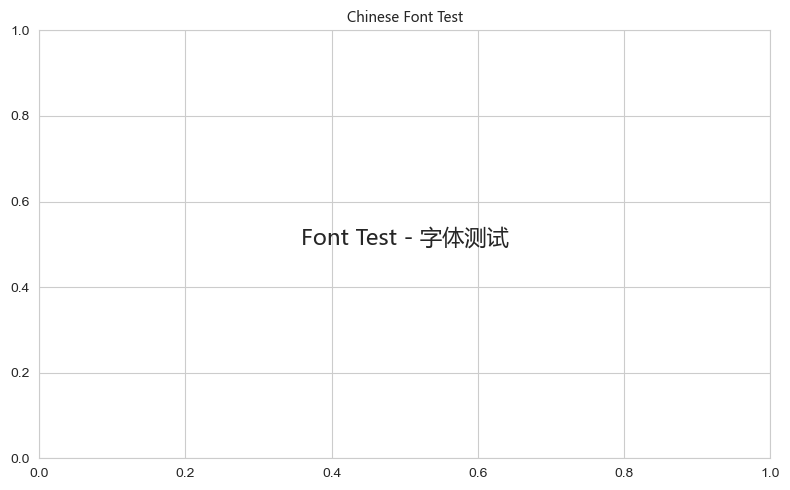

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path


def get_font_path():
    """尝试找到系统中的中文字体"""
    import matplotlib.font_manager as fm
    
    # Windows系统常见中文字体路径
    windows_fonts = [
        r'C:\Windows\Fonts\msyh.ttc',      # 微软雅黑
        r'C:\Windows\Fonts\simhei.ttf',    # 黑体
        r'C:\Windows\Fonts\simsun.ttc',    # 宋体
        r'C:\Windows\Fonts\msyhbd.ttc',    # 微软雅黑Bold
    ]
    
    for font_path in windows_fonts:
        if os.path.exists(font_path):
            return font_path
    
    return None

# 尝试设置中文字体
font_path = get_font_path()
if font_path:
    from matplotlib.font_manager import FontProperties
    chinese_font = FontProperties(fname=font_path)
    print(f"找到中文字体: {font_path}")
# 设置图片样式
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.unicode_minus'] = False

# 定义标签字典 - 支持中英文切换
labels = {
    'real_impedance': "Z' (Real Impedance) / Ω" if chinese_font is None else "Z' (实部阻抗) / Ω",
    'imag_impedance': "-Z'' (Imaginary Impedance) / Ω" if chinese_font is None else "-Z'' (虚部阻抗) / Ω",
    'frequency': 'Frequency / Hz' if chinese_font is None else '频率 / Hz',
    'magnitude': '|Z| / Ω' if chinese_font is None else '|Z| / Ω',
    'phase': 'Phase / °' if chinese_font is None else '相位 / °',
    'nyquist': 'Nyquist Plot' if chinese_font is None else 'Nyquist图',
    'bode': 'Bode Plot' if chinese_font is None else 'Bode图',
    'raw_data': 'Raw Data' if chinese_font is None else '原始数据',
    'fitted_data': 'Fitted Data' if chinese_font is None else '拟合数据',
    'cycle': 'Cycle' if chinese_font is None else '循环',
}

print("标签字典已创建，图表将使用", "中文" if chinese_font else "英文", "标签")

# 测试图表
fig, ax = plt.subplots(figsize=(8, 5))
test_text = "Font Test - 字体测试"
if chinese_font:
    ax.text(0.5, 0.5, test_text, fontproperties=chinese_font, fontsize=16, ha='center')
    ax.set_title('Chinese Font Test', fontproperties=chinese_font)
else:
    ax.text(0.5, 0.5, "Font Test - Using English Labels", fontsize=16, ha='center')
    ax.set_title('English Labels Mode')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 数据导入模块

In [4]:
# 数据文件路径配置
data_path = Path(r"Impedance raw data and fitting data")

# 电池类型和对应的文件夹
battery_types = {
    'NCA': 'NCA battery',
    'NCM': 'NCM battery', 
    'NCM+NCA': 'NCM+NCA battery'
}

# 数据导入函数
def load_impedance_data(battery_type, file_name, sheet_name=None):
    """
    加载阻抗数据
    
    Parameters:
    - battery_type: 电池类型 ('NCA', 'NCM', 'NCM+NCA')
    - file_name: Excel文件名
    - sheet_name: 工作表名称，如果为None则返回所有工作表列表
    """
    file_path = data_path / battery_types[battery_type] / file_name
    
    if not file_path.exists():
        print(f"文件不存在: {file_path}")
        return None
    
    if sheet_name is None:
        # 返回所有工作表名称
        xl_file = pd.ExcelFile(file_path)
        return xl_file.sheet_names
    
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        # 清理数据，移除未命名的列
        df = df.dropna(axis=1, how='all')
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        return df
    except Exception as e:
        print(f"读取数据时出错: {e}")
        return None

# 循环次数计算函数
def calculate_cycle_number(sheet_index, battery_type):
    """
    根据工作表索引和电池类型计算循环次数
    
    Parameters:
    - sheet_index: 工作表索引 (从1开始)
    - battery_type: 电池类型
    """
    if battery_type == 'NCA':
        return (sheet_index - 1) * 25
    elif battery_type in ['NCM', 'NCM+NCA']:
        return (sheet_index - 1) * 50
    else:
        return 0


In [5]:
# 示例：加载NCA电池数据
nca_file = 'CY25_0.25_1.xlsx'
nca_sheets = load_impedance_data('NCA', nca_file)
print(f"NCA电池文件 {nca_file} 包含的工作表：")
print(nca_sheets)

# 加载第一个工作表的数据
if nca_sheets:
    sample_data = load_impedance_data('NCA', nca_file, nca_sheets[0])
    print(f"\n工作表 '{nca_sheets[0]}' 的数据结构：")
    print(f"数据维度: {sample_data.shape}")
    print(f"列名: {sample_data.columns.tolist()}")
    print(f"\n前5行数据：")
    print(sample_data.head())

NCA电池文件 CY25_0.25_1.xlsx 包含的工作表：
['1_1RCPE', '2_1RCPE', '3_2RCPE', '4_2RCPE', '5_2RCPE', '6_2RCPE', '7_2RCPE', '8_2RCPE', '9_2RCPE', '10_2RCPE', '11_2RCPE', '12_2RCPE', '13_2RCPE', '14_2RCPE', '15_2RCPE']

工作表 '1_1RCPE' 的数据结构：
数据维度: (102, 6)
列名: ['Data: Frequency', "Data: Z'", "Data: Z''", 'Fit: Frequency', "Fit: Z'", "Fit: Z''"]

前5行数据：
   Data: Frequency  Data: Z'  Data: Z''  Fit: Frequency   Fit: Z'  Fit: Z''
0         0.046566  0.032083  -0.006005        0.046566  0.032241 -0.006499
1         0.055879  0.031736  -0.005451        0.055879  0.031675 -0.005935
2         0.062864  0.031432  -0.005170        0.062864  0.031336 -0.005596
3         0.067521  0.031253  -0.004965        0.067521  0.031139 -0.005401
4         0.076834  0.030945  -0.004753        0.076834  0.030801 -0.005065


## 数据绘图函数

In [6]:
# 阻抗数据绘图函数 - 修复中文显示
def plot_nyquist(data, title="Nyquist图", show_fit=True, figsize=(10, 8)):
    """
    绘制Nyquist图（阻抗复平面图）
    
    Parameters:
    - data: 包含阻抗数据的DataFrame
    - title: 图表标题
    - show_fit: 是否显示拟合数据
    - figsize: 图片大小
    """
    plt.figure(figsize=figsize)
    
    # 绘制原始数据
    if "Data: Z'" in data.columns and "Data: Z''" in data.columns:
        plt.scatter(data["Data: Z'"], -data["Data: Z''"], 
                   alpha=0.7, s=50, label=labels['raw_data'], color='blue')
    
    # 绘制拟合数据（如果存在且要求显示）
    if show_fit and "Fit: Z'" in data.columns and "Fit: Z''" in data.columns:
        plt.plot(data["Fit: Z'"], -data["Fit: Z''"], 
                'r-', linewidth=2, label=labels['fitted_data'], alpha=0.8)
    
    plt.xlabel(labels['real_impedance'], fontproperties=chinese_font if chinese_font else None)
    plt.ylabel(labels['imag_impedance'], fontproperties=chinese_font if chinese_font else None)
    
    if chinese_font:
        plt.title(title, fontproperties=chinese_font)
    else:
        plt.title(title)
    
    plt.legend(prop=chinese_font if chinese_font else None)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def plot_bode(data, title="Bode图", figsize=(12, 8)):
    """
    绘制Bode图（频率响应图）
    
    Parameters:
    - data: 包含阻抗数据的DataFrame
    - title: 图表标题
    - figsize: 图片大小
    """
    if "Data: Frequency" not in data.columns:
        print("数据中缺少频率信息")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # 计算阻抗模长
    if "Data: Z'" in data.columns and "Data: Z''" in data.columns:
        impedance_magnitude = np.sqrt(data["Data: Z'"]**2 + data["Data: Z''"]**2)
        phase = np.arctan2(-data["Data: Z''"], data["Data: Z'"]) * 180 / np.pi
        
        # 阻抗模长 vs 频率
        ax1.loglog(data["Data: Frequency"], impedance_magnitude, 'bo-', markersize=4, label=labels['raw_data'])
        ax1.set_xlabel(labels['frequency'], fontproperties=chinese_font if chinese_font else None)
        ax1.set_ylabel(labels['magnitude'], fontproperties=chinese_font if chinese_font else None)
        
        title_mag = f"{title} - 阻抗模长" if chinese_font else f"{title} - Magnitude"
        ax1.set_title(title_mag, fontproperties=chinese_font if chinese_font else None)
        ax1.grid(True, alpha=0.3)
        ax1.legend(prop=chinese_font if chinese_font else None)
        
        # 相位 vs 频率
        ax2.semilogx(data["Data: Frequency"], phase, 'ro-', markersize=4, label=labels['raw_data'])
        ax2.set_xlabel(labels['frequency'], fontproperties=chinese_font if chinese_font else None)
        ax2.set_ylabel(labels['phase'], fontproperties=chinese_font if chinese_font else None)
        
        title_phase = f"{title} - 相位" if chinese_font else f"{title} - Phase"
        ax2.set_title(title_phase, fontproperties=chinese_font if chinese_font else None)
        ax2.grid(True, alpha=0.3)
        ax2.legend(prop=chinese_font if chinese_font else None)
    
    plt.tight_layout()
    plt.show()

def plot_comparison(battery_type, file_name, sheet_names, plot_type='nyquist'):
    """
    比较不同循环次数的阻抗数据
    
    Parameters:
    - battery_type: 电池类型
    - file_name: 文件名
    - sheet_names: 要比较的工作表名称列表
    - plot_type: 绘图类型 ('nyquist' 或 'bode')
    """
    plt.figure(figsize=(12, 10))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(sheet_names)))
    
    for i, sheet_name in enumerate(sheet_names):
        data = load_impedance_data(battery_type, file_name, sheet_name)
        if data is None:
            continue
            
        # 提取工作表索引号用于计算循环次数
        sheet_index = int(sheet_name.split('_')[0])
        cycle_num = calculate_cycle_number(sheet_index, battery_type)
        
        if plot_type == 'nyquist':
            if "Data: Z'" in data.columns and "Data: Z''" in data.columns:
                plt.scatter(data["Data: Z'"], -data["Data: Z''"], 
                           alpha=0.7, s=30, color=colors[i], 
                           label=f'{labels["cycle"]} {cycle_num}')
        elif plot_type == 'bode':
            if "Data: Frequency" in data.columns and "Data: Z'" in data.columns and "Data: Z''" in data.columns:
                impedance_magnitude = np.sqrt(data["Data: Z'"]**2 + data["Data: Z''"]**2)
                plt.loglog(data["Data: Frequency"], impedance_magnitude, 
                          'o-', markersize=3, color=colors[i], 
                          label=f'{labels["cycle"]} {cycle_num}')
    
    if plot_type == 'nyquist':
        plt.xlabel(labels['real_impedance'], fontproperties=chinese_font if chinese_font else None)
        plt.ylabel(labels['imag_impedance'], fontproperties=chinese_font if chinese_font else None)
        
        title_text = f"{battery_type}电池 - Nyquist图比较 ({file_name})" if chinese_font else f"{battery_type} Battery - Nyquist Comparison ({file_name})"
        plt.title(title_text, fontproperties=chinese_font if chinese_font else None)
        plt.axis('equal')
    elif plot_type == 'bode':
        plt.xlabel(labels['frequency'], fontproperties=chinese_font if chinese_font else None)
        plt.ylabel(labels['magnitude'], fontproperties=chinese_font if chinese_font else None)
        
        title_text = f"{battery_type}电池 - Bode图比较 ({file_name})" if chinese_font else f"{battery_type} Battery - Bode Comparison ({file_name})"
        plt.title(title_text, fontproperties=chinese_font if chinese_font else None)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=chinese_font if chinese_font else None)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## 数据使用实例
* 单个阻抗图
* 多次循环阻抗图对比
* NCA和NCM等效电路模型对比

=== 单个阻抗数据可视化示例 ===
成功加载NCA电池数据，绘制Nyquist图...


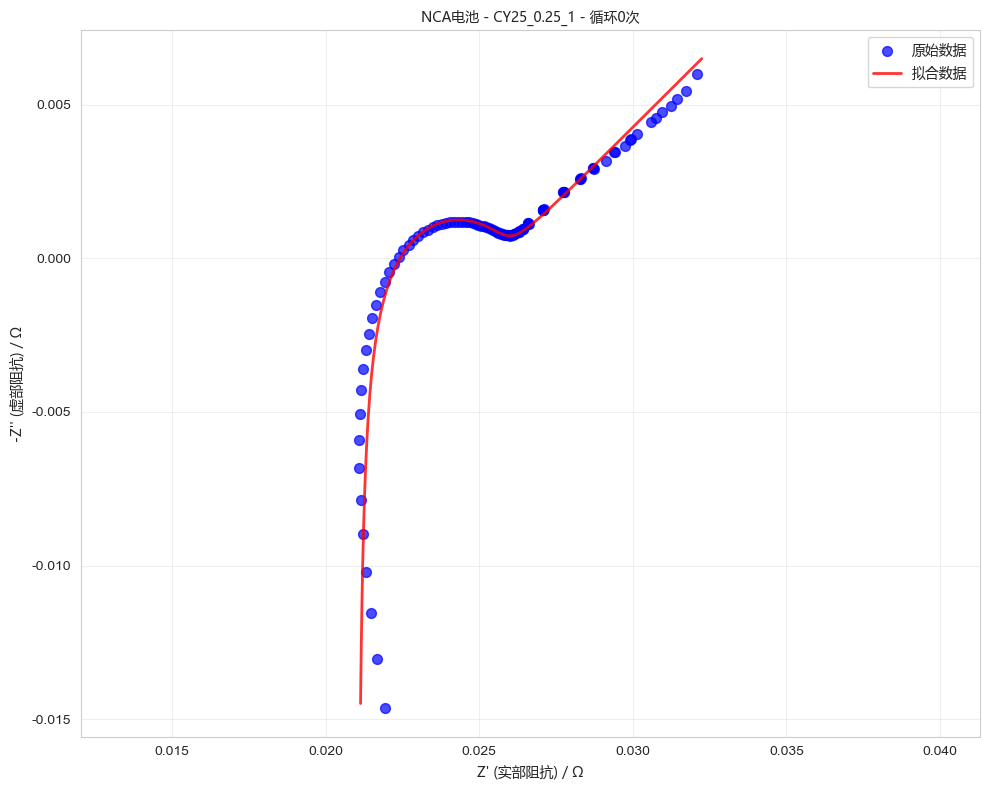

In [7]:
# 实际使用示例 - 绘制单个阻抗图
print("=== 单个阻抗数据可视化示例 ===")

# 加载并绘制NCA电池的第一个数据集
nca_data = load_impedance_data('NCA', 'CY25_0.25_1.xlsx', '1_1RCPE')
if nca_data is not None:
    print("成功加载NCA电池数据，绘制Nyquist图...")
    plot_nyquist(nca_data, "NCA电池 - CY25_0.25_1 - 循环0次", show_fit=True)

=== Bode图绘制示例 ===


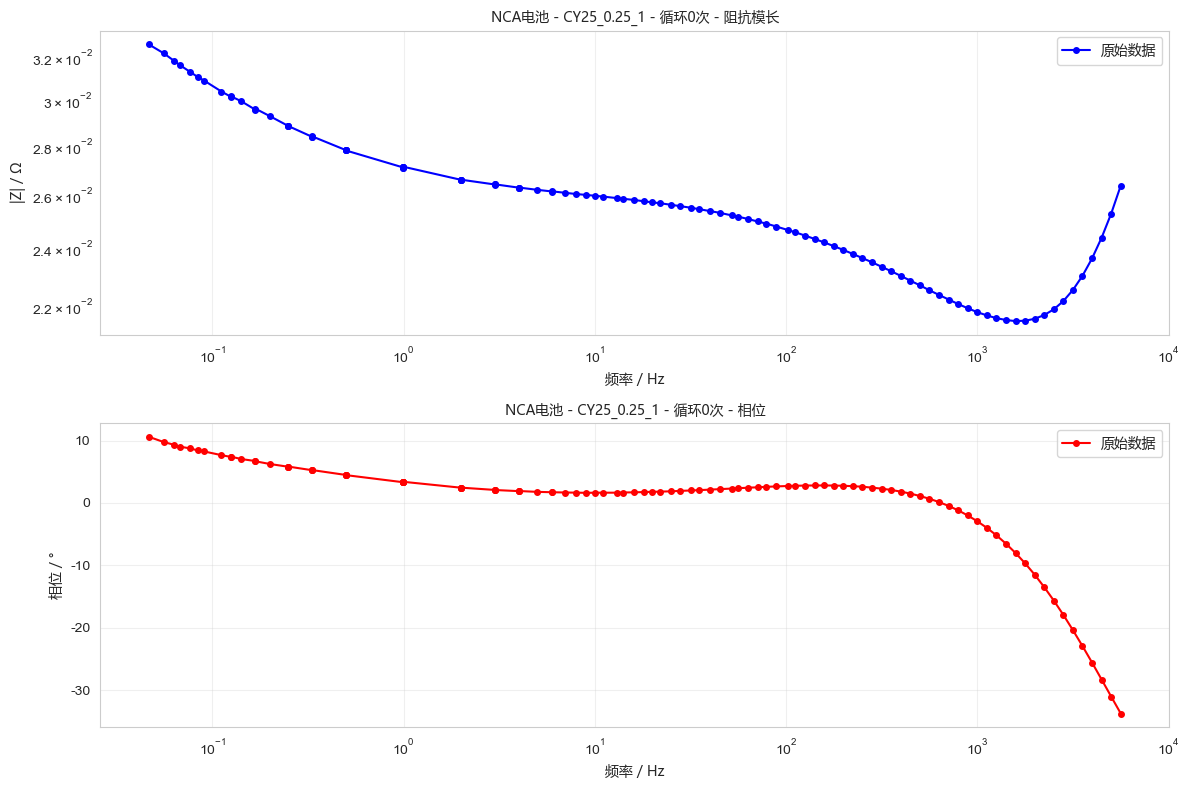

In [8]:
# 绘制Bode图
print("=== Bode图绘制示例 ===")
if nca_data is not None:
    plot_bode(nca_data, "NCA电池 - CY25_0.25_1 - 循环0次")

=== 多循环次数阻抗比较示例 ===
绘制不同循环次数的Nyquist图比较...


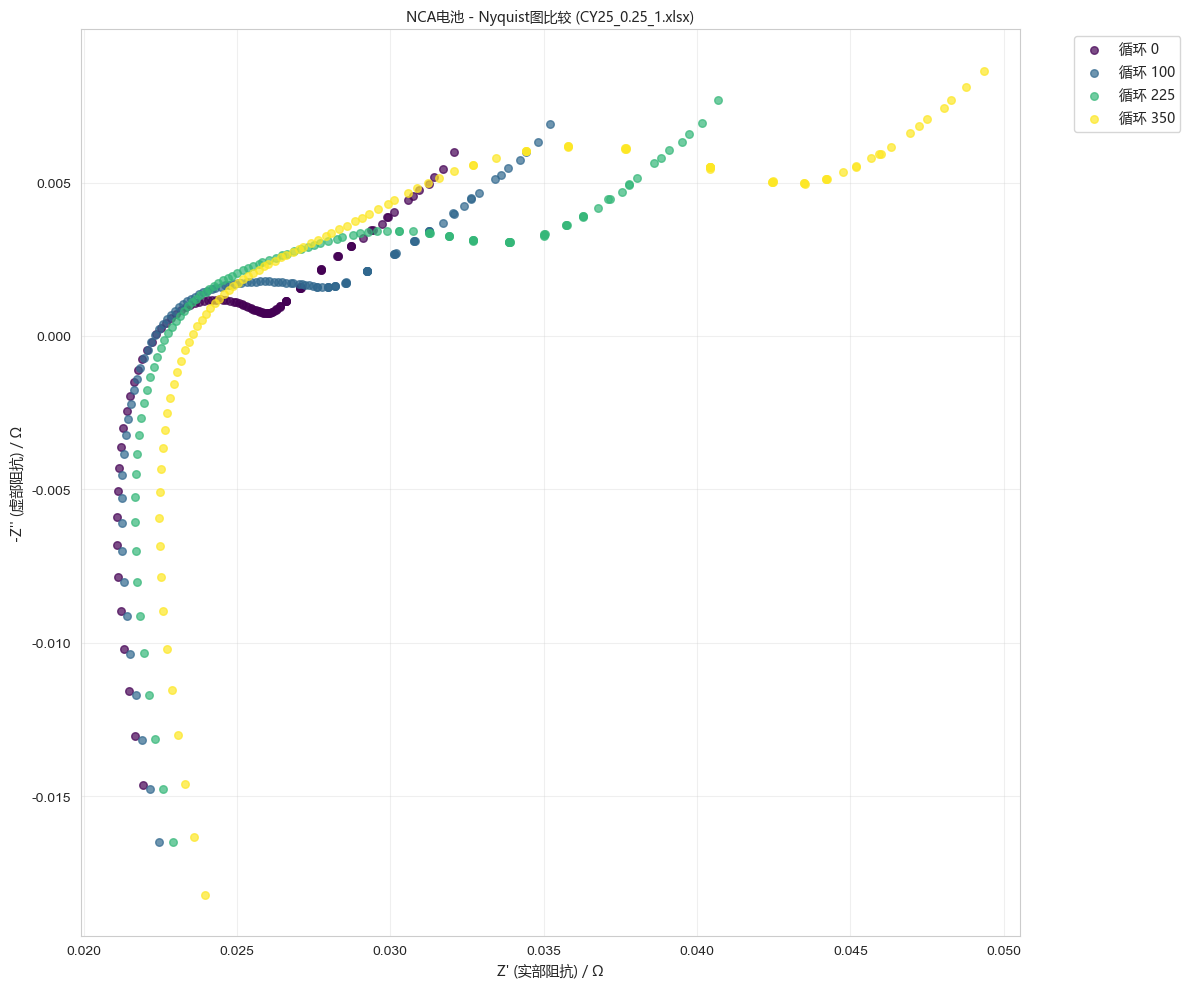

In [9]:
# 多循环次数比较
print("=== 多循环次数阻抗比较示例 ===")

# 选择几个代表性的工作表进行比较
comparison_sheets = ['1_1RCPE', '5_2RCPE', '10_2RCPE', '15_2RCPE']  # 对应循环0, 100, 225, 350次

print("绘制不同循环次数的Nyquist图比较...")
plot_comparison('NCA', 'CY25_0.25_1.xlsx', comparison_sheets, 'nyquist')

=== 不同电池类型阻抗比较示例 ===
读取数据时出错: bad operand type for unary ~: 'float'


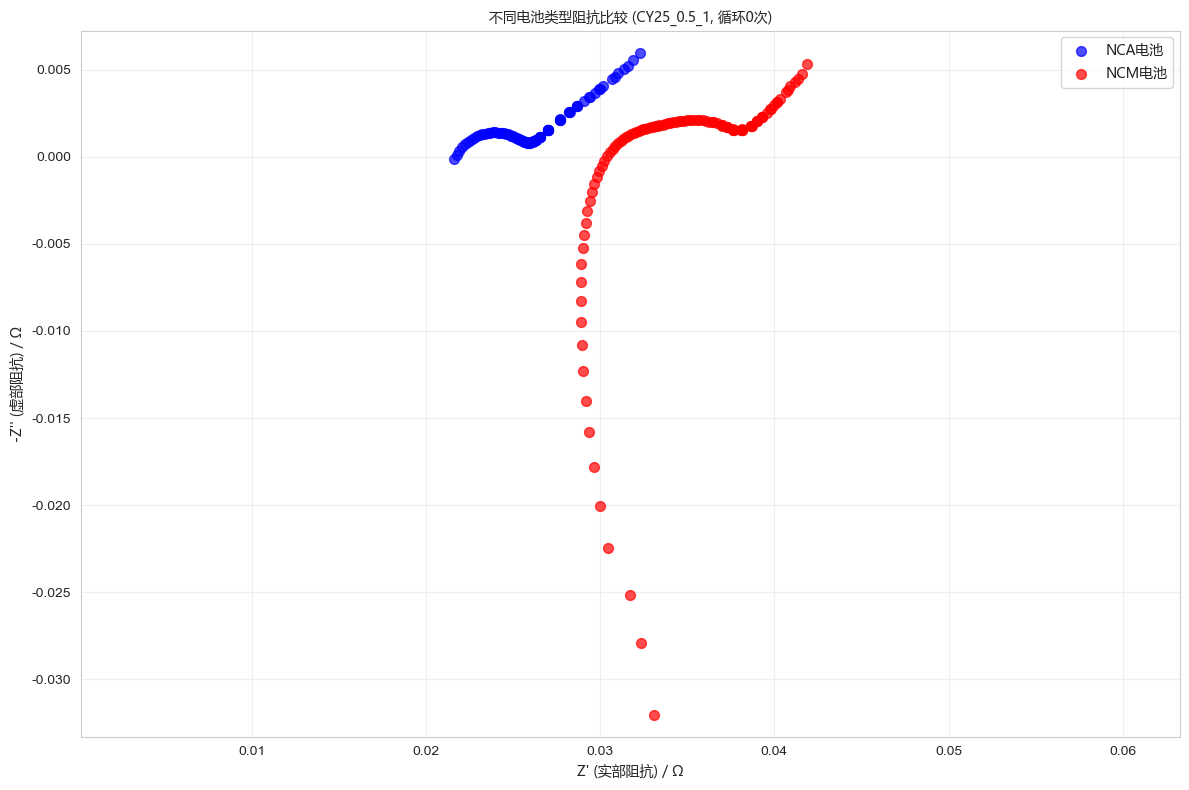

In [10]:
# 不同电池类型比较 - 修复中文显示
print("=== 不同电池类型阻抗比较示例 ===")

# 比较不同电池类型在相同条件下的阻抗特性
plt.figure(figsize=(12, 8))

# NCA电池 - 使用1_1RCPE工作表
nca_data_comp = load_impedance_data('NCA', 'CY25_0.5_1.xlsx', '1_1RCPE')
if nca_data_comp is not None:
    plt.scatter(nca_data_comp["Data: Z'"], -nca_data_comp["Data: Z''"], 
               alpha=0.7, s=50, label='NCA电池', color='blue')

# NCM电池 - 使用1工作表
ncm_data_comp = load_impedance_data('NCM', 'CY25_0.5_1.xlsx', '1')
if ncm_data_comp is not None:
    plt.scatter(ncm_data_comp["Data: Z'"], -ncm_data_comp["Data: Z''"], 
               alpha=0.7, s=50, label='NCM电池', color='red')

# NCM+NCA电池 - 使用1工作表
ncm_nca_data_comp = load_impedance_data('NCM+NCA', 'CY25_0.5_1.xlsx', '1')
if ncm_nca_data_comp is not None:
    plt.scatter(ncm_nca_data_comp["Data: Z'"], -ncm_nca_data_comp["Data: Z''"], 
               alpha=0.7, s=50, label='NCM+NCA电池', color='green')

plt.xlabel(labels['real_impedance'], fontproperties=chinese_font if chinese_font else None)
plt.ylabel(labels['imag_impedance'], fontproperties=chinese_font if chinese_font else None)

title_text = "不同电池类型阻抗比较 (CY25_0.5_1, 循环0次)" if chinese_font else "Battery Type Comparison (CY25_0.5_1, Cycle 0)"
plt.title(title_text, fontproperties=chinese_font if chinese_font else None)

plt.legend(prop=chinese_font if chinese_font else None)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [11]:
# 数据分析和统计
print("=== 数据分析和统计 ===")

def analyze_impedance_data(battery_type, file_name):
    """
    分析单个文件的阻抗数据统计信息
    """
    print(f"\n--- {battery_type}电池 ({file_name}) 数据分析 ---")
    
    # 获取所有工作表
    sheets = load_impedance_data(battery_type, file_name)
    if not sheets:
        print("无法加载数据")
        return
    
    print(f"总工作表数量: {len(sheets)}")
    
    # 分析第一个和最后一个工作表的数据
    first_sheet = sheets[0]
    last_sheet = sheets[-1]
    
    first_data = load_impedance_data(battery_type, file_name, first_sheet)
    last_data = load_impedance_data(battery_type, file_name, last_sheet)
    
    if first_data is not None and last_data is not None:
        # 计算阻抗变化
        first_z_real_avg = first_data["Data: Z'"].mean()
        last_z_real_avg = last_data["Data: Z'"].mean()
        
        first_z_imag_avg = first_data["Data: Z''"].mean()
        last_z_imag_avg = last_data["Data: Z''"].mean()
        
        print(f"初始阻抗实部平均值: {first_z_real_avg:.6f} Ω")
        print(f"最终阻抗实部平均值: {last_z_real_avg:.6f} Ω")
        print(f"阻抗实部变化: {((last_z_real_avg - first_z_real_avg) / first_z_real_avg * 100):.2f}%")
        
        print(f"初始阻抗虚部平均值: {first_z_imag_avg:.6f} Ω")
        print(f"最终阻抗虚部平均值: {last_z_imag_avg:.6f} Ω")
        print(f"阻抗虚部变化: {((last_z_imag_avg - first_z_imag_avg) / abs(first_z_imag_avg) * 100):.2f}%")

# 分析所有可用的电池数据
for battery_type in ['NCA', 'NCM', 'NCM+NCA']:
    folder_path = data_path / battery_types[battery_type]
    if folder_path.exists():
        excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
        for file_name in excel_files[:1]:  # 只分析第一个文件作为示例
            analyze_impedance_data(battery_type, file_name)

=== 数据分析和统计 ===

--- NCA电池 (CY25_0.25_1.xlsx) 数据分析 ---
总工作表数量: 15
初始阻抗实部平均值: 0.025596 Ω
最终阻抗实部平均值: 0.032256 Ω
阻抗实部变化: 26.02%
初始阻抗虚部平均值: -0.000394 Ω
最终阻抗虚部平均值: -0.002162 Ω
阻抗虚部变化: -448.57%

--- NCM电池 (CY25_0.5_1.xlsx) 数据分析 ---
总工作表数量: 9
初始阻抗实部平均值: 0.034669 Ω
最终阻抗实部平均值: 0.046758 Ω
阻抗实部变化: 34.87%
初始阻抗虚部平均值: 0.000847 Ω
最终阻抗虚部平均值: -0.003095 Ω
阻抗虚部变化: -465.57%

--- NCM+NCA电池 (CY25_0.5_1.xlsx) 数据分析 ---
总工作表数量: 21
读取数据时出错: bad operand type for unary ~: 'float'
